<a href="https://colab.research.google.com/github/femIA2020/FEM_IA/blob/master/MODELO_GNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Open csv 
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
pd.options.mode.chained_assignment = None

sentences = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/saturday ia/justicia abierta/csv/sentencias_dataframe.csv")

In [ ]:
sentences.info()

In [ ]:
# There are missing values in dataframe , column 'CORPUS'
nan_values = sentences [sentences ["CORPUS"].isnull() == True ] 
nan_values

In [ ]:
 #Only take values that are not missing and check again shape 
sentences = sentences[sentences['CORPUS'].notnull()]
sentences.info()

In [ ]:
sentences['PUNTUACIÓN'].mean()

In [ ]:
# Add new column : PG if punctuation is greater than 6 then is a sentence that contains PERSPECTIVA DE GÉNERO and if not then is FALSE. 
sentences['PG'] = np.where(sentences['PUNTUACIÓN'] > 6, True, False)


In [ ]:
#DATAVIZ : ASUNTO/TEMA

import matplotlib.pyplot as plt

from wordcloud import WordCloud
wordcloud = WordCloud().generate(" ".join(sentences['ASUNTO/TEMA']))

plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
#EDA : ASUNTO/TEMA

plt.rcParams["figure.figsize"] = (10,20)
sentences['ASUNTO/TEMA'].value_counts().plot(kind ='barh')

In [ ]:
#EDA : INSTANCIA
sentences['INSTANCIA'].value_counts().plot(kind ='barh')

In [ ]:
#PUNTUACION 
sentences['PUNTUACIÓN'].plot.box(title="Puntuación de perspectiva de género", grid=True);

plt.show(block=True)

In [ ]:
import seaborn as sn
ax = sn.boxplot(sentences['PUNTUACIÓN'])
plt.show()

In [ ]:
# Pra ver todo el corpus: aun hay nombres propios, acentros, caracteres especiales como asteriscos y , quitar nombre de ACsnumeros, qué pasa con los NAN, quitar numeros
#from google.colab.data_table import DataTable
#%load_ext google.colab.data_table
#DataTable(sentences)

In [ ]:
sentences['CORPUS'] = sentences['CORPUS'].astype(str)

In [ ]:
# Remove punctuation : checar, se están pasando acentos

PUNCT_TO_REMOVE = string.punctuation #String punctuation default symbols:!"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
def remove_punctuation(text):
  return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
sentences["text_wo_punct"] = sentences["CORPUS"].apply(lambda text: remove_punctuation(text))


In [ ]:
# remove stop words : #ACA FALTAN MÁS STOPWORDS COMO DOS O SI 

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('spanish'))
STOPWORDS = list(STOPWORDS) + ["dos","mil"," ”"," “"," “","i"] #here we can add more stopwords to eliminate

def remove_stopwords(text):
   return " ".join([word for word in str(text).split() if word not in STOPWORDS])

sentences["text_wo_stop"] = sentences["text_wo_punct"].apply(lambda text: remove_stopwords(text))

In [ ]:
#Stemming : no se ve muy bien 

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

sentences["text_stemmed"] = sentences["text_wo_stop"].apply(lambda text: stem_words(text))




In [ ]:
#test/train

from sklearn.model_selection import train_test_split 

X_unscaled = pd.DataFrame(sentences)
#X_unscaled.drop ('score', axis = 1 , inplace = True)

y = pd.Series(sentences.PG, name = "PG")
y=y.astype('int')

#Split dataset : 80% training set & 20% test set 
X_train, X_test, y_train, y_test = train_test_split(X_unscaled,y, test_size=0.2, random_state=0)



In [ ]:
# print lenght of train & test
ds_train = X_train
ds_test = X_test
print("Number of records in Train data set",len(ds_train.index))

In [ ]:
# Create dictionary 

corpus  = ds_train['text_stemmed'] #acá el corpus debería ser lemma o stemm

uniqueWords = {}
for text in corpus:
    for word in text.split():
        if(word in uniqueWords.keys()):
            uniqueWords[word] += 1
        else:
            uniqueWords[word] = 1
            
#Convert dictionary to dataFrame
uniqueWords = pd.DataFrame.from_dict(uniqueWords,orient='index',columns=['WordFrequency'])
uniqueWords.sort_values(by=['WordFrequency'], inplace=True, ascending=False)
print("Number of records in Unique Words Data frame are {}".format(len(uniqueWords)))
uniqueWords.head(25)

In [ ]:
# Trabajar solo con las palabras que se repiten màs de 50x 

uniqueWords=uniqueWords[uniqueWords['WordFrequency']>=50]
print("Number of records in Unique Words Data frame are {}".format(len(uniqueWords)))


In [ ]:
import matplotlib.pyplot as plt


from wordcloud import WordCloud
wordcloud = WordCloud().generate(" ".join(corpus))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#BAG OF WORDS

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = len(uniqueWords))

#Create Bag of Words Model , here X represent bag of words
X = cv.fit_transform(corpus).todense()
y = ds_train['PG'].values
y=y.astype('int') #There was a mistake in GNB given the fact that this column wasn't integer

In [ ]:
#Split the train data set to train and test data
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2, random_state=0)
print('Train Data splitted successfully')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer 

#Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
classifier_gnb = GaussianNB();
classifier_gnb.fit(X_train, y_train)

# Predicting the Train data set results
y_pred_gnb = classifier_gnb.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
cm_gnb

In [ ]:
#MODEL ACCURACY 

from sklearn.metrics import f1_score

print('GaussianNB Classifier Accuracy Score is {} for Train Data Set'.format(classifier_gnb.score(X_train, y_train)))
print('GaussianNB Classifier Accuracy Score is {} for Test Data Set'.format(classifier_gnb.score(X_test, y_test)))
print('GaussianNB Classifier F1 Score is {}'.format(f1_score(y_test, y_pred_gnb))) #does not run

In [ ]:
#Fitting into test set
X_testset = X_test


In [ ]:
#Predict data with classifier created in previous section
y_test_pred_gnb = classifier_gnb.predict(X_testset)
y_test_pred_gnb

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

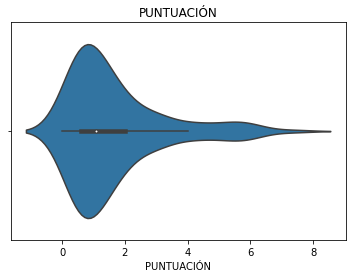

In [6]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt


plt.title("PUNTUACIÓN")
sns.violinplot( x=sentences["PUNTUACIÓN"]  )
plt.savefig("/content/drive/MyDrive/Colab Notebooks/saturday ia/justicia abierta/csv/")